# A look at co-speciation in flish poo

In [3]:
%pylab inline
%load_ext retina

Populating the interactive namespace from numpy and matplotlib


### Import OTU table, sample metadata and host tree

We use python's biom module to extract the OTU counts from the .biom file QIIME gave us. In principle, we could use the biom object to do various slicing and dicing, but the module is confusing and weird. So, we just shove the OTU counts into a pandas dataframe and move on.

Next, we import the sample metadata, which we use to drop the control samples and the other experiments, and to merge the OTU counts for samples that have the same host species.

Last, we use rpy2 to import the host phylogeny. This is silly, but all of the tests for phylogenetic signal are in R, so we need to have the host tree as an R object.

In [11]:
import pandas as pd
import numpy as np
import biom
import csv

def exploding_panda(_bt):
    m = _bt.matrix_data
    data = [pd.SparseSeries(m[i].toarray().ravel()) for i in np.arange(m.shape[0])]
    out = pd.SparseDataFrame(data, index=_bt.ids('observation'),
                             columns=_bt.ids('sample'))

    return out

phase1_otus = exploding_panda( biom.load_table('fishpoo_open97/fishpoo_phase1.biom') )

# load the QIIME mapping file (i.e., the sample metadata)
mapping = []
with open("fishpoo_map.tsv") as f :
    for n,row in enumerate(csv.reader(f, delimiter='\t')) :
        if n == 0 : colnames = row; continue
        mapping.append( dict( zip( colnames, row ) ) )

mapping = pd.DataFrame( mapping )

phase_1 = mapping[mapping.Experiment == 'Phase I']

# drop the samples that aren't fish
phase_1 = phase_1[phase_1['#SampleID'].isin(['KITCNT1', 'CHARCNT', 'WATERCNT', 'FOOD', 'Neg.Control.1' ]) == False]

# give me a table mapping sample IDs to the host taxon
host_names = phase_1[['#SampleID','Host']]

# Take the OTU counts for host taxa with more than one 
# individual, and merge them (basically, and inner join),
# and then normalize the OTU counts for each taxa to 1
merged_counts = pd.merge(pd.DataFrame( phase1_otus.T ), 
                         host_names, 
                         left_index=True, 
                         right_on='#SampleID').groupby('Host').sum()
del merged_counts['#SampleID']
merged_counts = merged_counts.div( merged_counts.sum(axis=1), axis=0)

# Let's try to talk to R from python. Then I don't have to figure out 
# how to do parsing, logic and flow control in R anymore

from rpy2.robjects.packages import importr
import rpy2.robjects as ro

# R namespaces are kind of a joke
ape_translations = {'delta.plot'            : 'delta_plot',
                    'delta_plot'            : 'delta__plot',
                    'dist.dna'              : 'dist_dna',
                    'dist_dna'              : 'dist__dna',
                    'dist.nodes'            : 'dist_nodes',
                    'dist_nodes'            : 'dist__nodes',
                    'node.depth'            : 'node_depth',
                    'node_depth'            : 'node__depth',
                    'node.depth.edgelength' : 'node_depth_edgelength',
                    'node_depth_edgelength' : 'node__depth__edgelength',
                    'node.height'           : 'node_height',
                    'node_height'           : 'node__height', 
                    'node.height.clado'     : 'node_height_clado',
                    'node_height_clado'     : 'node__height__clado',
                    'prop.part'             : 'prop_part',
                    'prop_part'             : 'prop__part', }
ape = importr('ape', robject_translations = ape_translations )

phytools = importr('phytools')

adephylo = importr('adephylo')
phylobase = importr('phylobase')

# read in the big fish tree
rabosky = ape.read_tree( "host_tree/raboskytree/Rabosky_et_al_timetree.tre" )

# compute the list of taxa to drop from the big fish tree
myfishnames  = set(open("host_tree/raboskytree/fish_names.txt").read().split())
allfishnames = set(rabosky.rx('tip.label')[0])
dropnames    = allfishnames.difference(myfishnames)

# drop the fish I don't need
rabosky_trimmed = ape.drop_tip( rabosky, ro.vectors.StrVector( list(dropnames) ) )

# not all of my fish are in the big tree, so we're going to use
# their sister taxa as stand-ins
rabosky_trimmed[2][ rabosky_trimmed[2].index('Neolamprologus_cylindricus')   ] = "Neolamprologus_buescheri"
rabosky_trimmed[2][ rabosky_trimmed[2].index('Cyprichromis_jumbo')           ] = "Cyprichromis_coloratus"
rabosky_trimmed[2][ rabosky_trimmed[2].index('Baileychromis_centropomoides') ] = "Reganochromis_calliurus"
rabosky_trimmed[2][ rabosky_trimmed[2].index('Limnochromis_abeelei')         ] = "Trematochromis_benthicola"

### Wrappers for the nasty bits

In [12]:
import subprocess
import dendropy

microbe_tree = dendropy.Tree.get( path='fishpoo_open97/rep_set.tre', schema='newick')

# given a list of OTUs, merge their OTU counts and return an rpy2 R vector
# of those counts, with the host species names as the vector index
def tree_trait( otu_names, merged_counts ) :
    # The bacteria/archaea tree may contain leaves that are not in
    # our OTU table. Those weren't observed, so we just drop them;
    # it works out the same as zero counts for all hosts.
    otu_names = list( set(otu_names).intersection(set(merged_counts.columns) ) )
    trait_table = merged_counts[ otu_names ].sum(axis=1).to_dict()
    for key in trait_table.keys() :
        trait_table[ key.replace( ' ', '_' ) ] = trait_table[key]
        del trait_table[key]
    r_trate_table = ro.vectors.FloatVector(trait_table.values())
    r_trate_table.names = trait_table.keys()
    return r_trate_table

# wrapper for the calls into R via rpy2 to calculate phylogenetic signal
def psigs( leafs, host_tree, counts ) :
    tt = tree_trait( leafs, counts )
    K = phytools.phylosig( host_tree, tt, method='K' )[0]
    l_lambda, l_logL = map( lambda x : x[0], phytools.phylosig( host_tree, tt, method='lambda' ) )
    I = adephylo.abouheif_moran( phylobase.phylo4d( host_tree, tt ), method="Abouheif" )[1][0]
    Cmean = adephylo.abouheif_moran( phylobase.phylo4d( host_tree, tt ), method="oriAbouheif" )[1][0]
    return { 'K' : K, 'l_lambda' : l_lambda, 'l_logL' : l_logL, 'I' : I, 'Cmean' : Cmean }

# wrapper for Dongying Wu's TreeOTU program
def TreeOTU( i ) :
    return map( lambda x : x.split(','), subprocess.check_output(['TreeOTU/TreeOTU.pl', 
                                                                  '-i', 'fishpoo_open97/rep_set.tre', 
                                                                  '-c', str(i)]).split())[1:]


### Scan along the microbe tree with TreeOTU, calculate phylogenetic signals

Dongying's TreeOTU smashes the microbial tree of life into something like an ultrametric tree with a total branch length from tip to root of 1. Given some position on that interval, it returns the tips that fall within the same groups at the given depth.

We take several slices of the microbial tree of life, sum the OTU counts found in the groups below each slice, and then calculate Bloomberg's $K$, Abouheif's $C_{mean}$, Pagel's $\lambda$ and Moran's $I$ usint their respective R implementations.

We do the same thing with a table of random OTU counts.

There is a *lot* of intermediation going on here, so it is not swift.

In [13]:
import ProgressBar

N_tree_slices = 200

# build a table of random counts
random_counts = pd.DataFrame( np.random.random( merged_counts.shape ))
random_counts = random_counts.div( random_counts.sum(axis=1), axis=0 )
random_counts.set_axis( 0, merged_counts.axes[0] )
random_counts.set_axis( 1, merged_counts.axes[1] )

tree_scan = []
import ProgressBar

p = ProgressBar.ProgressBar(N_tree_slices)
for n,treelevel in enumerate(np.linspace(0.0,0.99,N_tree_slices)) :
    p.animate(n+1)
    K_d, l_lambda_d, l_logL_d, I_d, Cmean_d = [],[],[],[],[]
    K_r, l_lambda_r, l_logL_r, I_r, Cmean_r = [],[],[],[],[]
    groups = []
    for m,leafs in enumerate(TreeOTU(treelevel)) :
        sigs = psigs( leafs, rabosky_trimmed, merged_counts )
        K_d.append(sigs['K'])
        l_lambda_d.append(sigs['l_lambda'])
        l_logL_d.append(sigs['l_logL'])
        I_d.append(sigs['I'])
        Cmean_d.append(sigs['Cmean'])
        
        sigr = psigs( leafs, rabosky_trimmed, random_counts )
        K_r.append(sigr['K'])
        l_lambda_r.append(sigr['l_lambda'])
        l_logL_r.append(sigr['l_logL'])
        I_r.append(sigr['I'])
        Cmean_r.append(sigr['Cmean'])
    
        groups.append( leafs )
    tree_scan.append( { 'groups'    : groups, 
                        'K_d'       : K_d, 
                        'l_lambda_d': l_lambda_d,
                        'l_logL_d'  : l_logL_d,
                        'I_d'       : I_d,
                        'Cmean_d'   : Cmean_d,
                        'K_r'       : K_r,
                        'l_lambda_r': l_lambda_r,
                        'l_logL_r'  : l_logL_r,
                        'I_r'       : I_r,
                        'Cmean_r'   : Cmean_r,
                        'treelevel' : treelevel } )

[****************100%******************]  200 of 200 complete


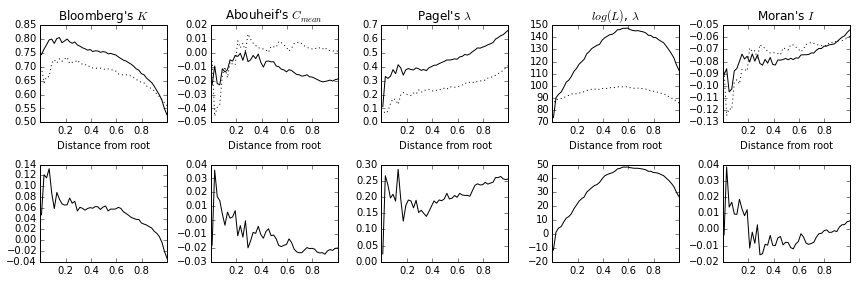

In [50]:
figure(figsize=(12, 4))

# this is dumb, but sadly necessary
def newsum( x ) :
    total = 0
    for i in x :
        if np.isfinite(i) : total += i
    return total

for i,d,r,t in [ (1, 'K_d', 'K_r', r"Bloomberg's $K$"),
                 (2, 'Cmean_d', 'Cmean_r', r"Abouheif's $C_{mean}$"),
                 (3, 'l_lambda_d', 'l_lambda_r', r"Pagel's $\lambda$"),
                 (4, 'l_logL_d', 'l_logL_r', r"$log(L)$, $\lambda$"),
                 (5, 'I_d', 'I_r', r"Moran's $I$") ] :
    psignal_data = np.array( map( lambda x: newsum(x[d])/len(x['groups']), tree_scan ) )
    psignal_rand = np.array( map( lambda x: newsum(x[r])/len(x['groups']), tree_scan ) )
    treelevels   = np.array( map( lambda x: x['treelevel'], tree_scan ) )
    subplot(2,5,i)
    plot( 1 - treelevels, psignal_data, linestyle='-', color='black' )
    plot( 1 - treelevels, psignal_rand, linestyle=':', color='black' )
    xticks([0.2,0.4,0.6,0.8])
    xlabel('Distance from root')
    title(t)
    subplot(2,5,i+5)
    plot( 1 - treelevels, psignal_data - psignal_rand, linestyle='-', color='black')
    xticks([0.2,0.4,0.6,0.8])
tight_layout()

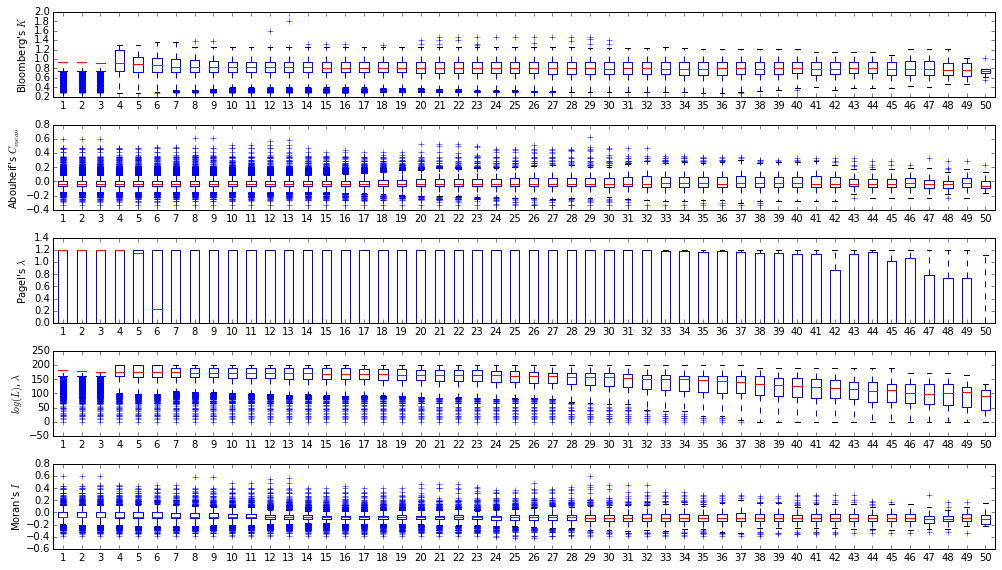

In [56]:
#plot( map(lambda x: x['treelevel'], tree_scan), map( lambda x: newsum(x['sigs'])/len(x['groups']), tree_scan ))
figure(figsize=(14, 8))
for i,d,r,t in [ (1, 'K_d', 'K_r', r"Bloomberg's $K$"),
                 (2, 'Cmean_d', 'Cmean_r', r"Abouheif's $C_{mean}$"),
                 (3, 'l_lambda_d', 'l_lambda_r', r"Pagel's $\lambda$"),
                 (4, 'l_logL_d', 'l_logL_r', r"$log(L)$, $\lambda$"),
                 (5, 'I_d', 'I_r', r"Moran's $I$") ] :
    subplot(5,1,i)
    signal_lists = []
    rsignal_lists = []
    for level in tree_scan :
        tl = level['treelevel']
        sd = level[d]
        sr = level[r]
        signal_lists.append(sd)
        rsignal_lists.append(sr)
    ylabel(t)
    p = boxplot(signal_lists)
tight_layout()

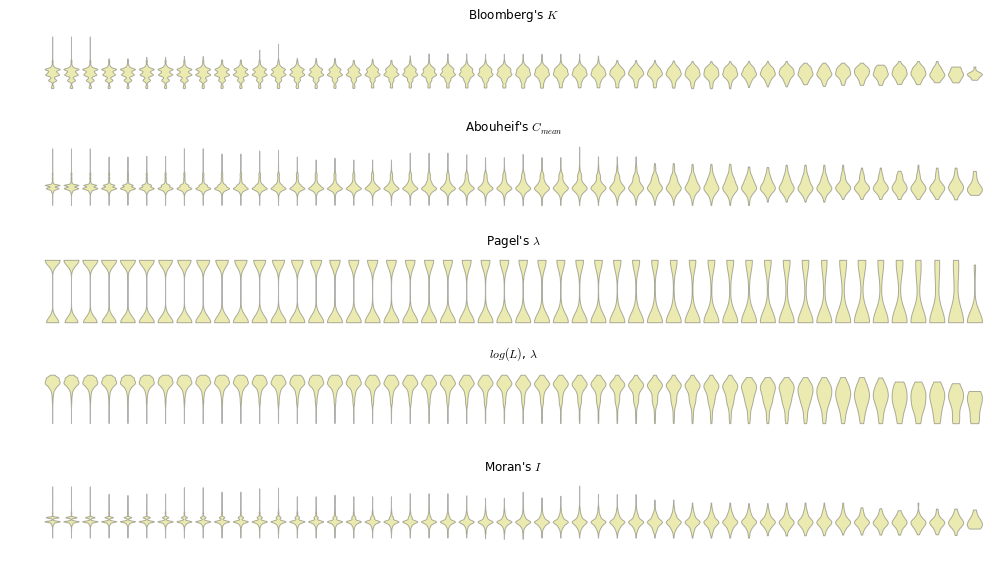

In [14]:
figure(figsize=(14, 8))
for i,d,r,t in [ (1, 'K_d', 'K_r', r"Bloomberg's $K$"),
                 (2, 'Cmean_d', 'Cmean_r', r"Abouheif's $C_{mean}$"),
                 (3, 'l_lambda_d', 'l_lambda_r', r"Pagel's $\lambda$"),
                 (4, 'l_logL_d', 'l_logL_r', r"$log(L)$, $\lambda$"),
                 (5, 'I_d', 'I_r', r"Moran's $I$") ] :
    subplot(5,1,i)
    signal_lists = []
    rsignal_lists = []
    for level in tree_scan :
        tl = level['treelevel']
        sd = level[d]
        sr = level[r]
        signal_lists.append(sd)
        rsignal_lists.append(sr)
    p1 = violinplot(map( lambda x : array(x)[~numpy.isnan(array(x))], signal_lists ), widths=0.8, showextrema=False )
    axis('off')
    title(t)
    xlim((0,51))
tight_layout()

In [7]:
import pandas as pd
with open('signal_data.csv', 'w') as f :
    f.write( ','.join( map( str, [ 'observation', 'type', 'treelevel', 'test' ] ) ) + '\n' )
    for d,r,t in [ ( 'K_d', 'K_r', 'K' ),
                   ( 'Cmean_d', 'Cmean_r', 'Cmean' ),
                   ( 'l_lambda_d', 'l_lambda_r', 'lambda' ),
                   ( 'l_logL_d', 'l_logL_r', 'l_logL' ),
                   ( 'I_d', 'I_r', 'I' ) ] :
        for level in tree_scan :
            tl = level['treelevel']
            sd = level[d]
            sr = level[r]
            for j in sd :
                f.write( ','.join( map( str, [ j, 'data', tl, t ] ) ) + '\n' )
            for j in sr :
                f.write( ','.join( map( str, [ j, 'rand', tl, t ] ) ) + '\n' )
TreeData = pd.read_csv( 'signal_data.csv' )

In [8]:
import pandas as pd
import seaborn
TreeData = pd.read_csv( 'signal_data.csv' )
figure(figsize=(17, 10))
#seaborn.set_style('darkgrid')
seaborn.set(style="whitegrid", palette="pastel", color_codes=True)
seaborn.despine(left=True)
for i,d,t in [ (1, 'K', r"Bloomberg's $K$"),
                 (2, 'Cmean', r"Abouheif's $C_{mean}$"),
                 (3, 'lambda', r"Pagel's $\lambda$"),
                 (4, 'l_logL', r"$log(L)$, $\lambda$"),
                 (5, 'I', r"Moran's $I$") ] :
    ax = subplot(5,1,i)
    seaborn.violinplot( x="treelevel",
                        y="observation",
                        hue="type", 
                        data=TreeData[TreeData.test == d],
                        split=True, 
                        inner="quart",
                        palette={'data': "r", 'rand': "b"},
                        linewidth=1,
                        ax=ax )
    ylabel(t)
    xticks([])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
tight_layout()

In [4]:
import cPickle
#cPickle.dump( tree_scan, open( 'tree_scan.pickle', 'w' ) )
tree_scan = cPickle.load( open( 'tree_scan.pickle' ) )

In [5]:
tree_scan[0].keys()

['I_d',
 'I_r',
 'K_r',
 'Cmean_r',
 'l_lambda_r',
 'l_logL_r',
 'l_lambda_d',
 'treelevel',
 'groups',
 'l_logL_d',
 'K_d',
 'Cmean_d']

In [9]:
import pandas as pd
metrics = [ 'I_d', 'I_r', 
            'K_d', 'K_r', 
            'Cmean_d', 'Cmean_r', 
            'l_lambda_d', 'l_lambda_r', 'l_logL_d', 'l_logL_r' ]
with open( 'tree_scan.tsv', 'w' ) as f :
    f.write( '\t'.join( ['OTU', 'treelevel'] + metrics ) )
    for treeslice in tree_scan :
        for n,OTUgroup in enumerate(treeslice['groups']) : 
            for OTU in OTUgroup :
                f.write( '\t'.join( [OTU] + [str(treeslice['treelevel'])]           \
                                   + map( lambda x: str(treeslice[x][n]), metrics ) \
                                   + ['\n'] ) )
TreeScan = pd.read_table( 'tree_scan.tsv' )

In [21]:
#import pandas as pd
#TreeScan = pd.read_table( 'tree_scan.tsv' )
TreeScan.plot( kind='hexbin', figsize=(14, 4), gridsize=25, x='treelevel', y='I_d')

### Looking at all the OTUs

When we look at the trajectories of all the OTUs, we can see that there are perhaps some interesting patterns in there, but it's a bit confusing. Here, we've plotted trajectories of phylogenetic signal in black, and the trajectories of phylogenetic signal we calculated from the random OTU table in red.

In [118]:
figure(figsize=(14, 4))
for OTU, group in TreeScan.groupby('OTU') :
    plot( 1 - group.treelevel, group.Cmean_d, alpha=0.1, color='black' )
    plot( 1 - group.treelevel, group.Cmean_r, alpha=0.01, color='red' )

Let's see what happens with Abouheif's $C_{mean}$ if we exclude the trajectories that never rise above some arbitrary threshold. Again, signal for real OTU counts in black, random OTU counts in red.

In [117]:
figure(figsize=(14, 4))
for OTU, group in TreeScan.groupby('OTU') :
    if max(group.Cmean_d) < 0.5 : continue
    plot( 1 - group.treelevel, group.Cmean_d, alpha=0.1, color='black' )
    plot( 1 - group.treelevel, group.Cmean_r, alpha=0.1, color='red' )

That looked pretty promising, so let's pick out the top eight OTUs using each of the metrics (except Pagel's $\lambda$, which just bounces around between its extremes).

In [133]:
figure(figsize=(14, 4))

color_idx = np.linspace(0, 1, 8)
i = 0
for OTU, group in TreeScan.groupby('OTU') :
    if group.Cmean_d.tolist()[0] < 0.4 : continue
    plot( 1 - group.treelevel, group.Cmean_d, color=cm.Set2(color_idx[i]), label=OTU )
    i = i + 1
grid(b=False)
ylabel(r"Abouheif's $C_{mean}$")
legend( ncol=1, loc='center right', bbox_to_anchor=(1.3,0.5), scatterpoints=1 )

In [134]:
figure(figsize=(14, 4))
color_idx = np.linspace(0, 1, 8)
i = 0
for OTU, group in TreeScan.groupby('OTU') :
    if group.I_d.tolist()[0] < 0.35 : continue
    plot( 1 - group.treelevel, group.I_d, color=cm.Set2(color_idx[i]), label=OTU )
    i = i + 1
ylim(-0.6,0.8)
grid(b=False)
ylabel(r"Moran's $I$")
legend( ncol=1, loc='center right', bbox_to_anchor=(1.3,0.5), scatterpoints=1 )

In [135]:
figure(figsize=(14, 4))
color_idx = np.linspace(0, 1, 8)
i = 0
for OTU, group in TreeScan.groupby('OTU') :
    if group.K_d.tolist()[0] < 1.25 : continue
    if numpy.isnan(group.K_d.tolist()[0]) : continue
    plot( 1 - group.treelevel, group.K_d, color=cm.Set2(color_idx[i]),  label=OTU )
    i = i + 1
grid(b=False)
ylabel(r"Bloomberg's $K$")
legend( ncol=1, loc='center right', bbox_to_anchor=(1.3,0.5), scatterpoints=1 )

### We seem to get many of the same OTUs

That's encouraging.